<a href="https://colab.research.google.com/github/kjackson87/blog/blob/lunar_lander_2/_notebooks/2022-01-07-lunar_lander_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lunar Lander with Deep Q-Network (Part 2)

- toc: true 
- badges: true
- comments: false
- categories: [dqn, rl]

# Recap

> Note: The first part of this series can be found at [Part 1](/dqn/rl/2021/12/29/lunar_lander)

In the first part of this series, we implemented a DQN agent using the built in state output from the Gym environment. This state gives data on position, velociy, lander angle, and if either feet of the lander are touching the ground. For this second part, we'll up the ante and remove the state information, instead inferring state from the raw pixels of the game image.

We'll once again begin with imports as before.

In [14]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
from collections import deque, namedtuple
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
  !pip install box2d

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

In [15]:
SEED = 42

Add the ReplayMemory class as before to handle our Experience Replay.

In [30]:
Experience = namedtuple("Experience", field_names=[
                        "state", "action", "reward", "next_state", "done"])


class ReplayMemory(object):


  def __init__(self, buffer_size, batch_size, seed, device):
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size
    self.seed = random.seed(seed)
    self.device = device

  def push(self, *args):
    torch_args = [torch.tensor([arg]).to(self.device) for arg in args]
    self.memory.append(Experience(*torch_args))

  def sample(self, device):
    """ 
    Sample a set memories.
    """
    experiences = random.sample(self.memory, k=self.batch_size)

    states = torch.from_numpy(
        np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
    actions = torch.from_numpy(
        np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
    rewards = torch.from_numpy(
        np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
    next_states = torch.from_numpy(np.vstack(
        [e.next_state for e in experiences if e is not None])).float().to(self.device)
    dones = torch.from_numpy(np.vstack(
        [e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

    return (states, actions, rewards, next_states, dones)

  def __len__(self):
    return len(self.memory)

  def __repr__(self):
    return repr(self.memory)

  def __str__(self):
    return str(self.memory)


Our agent is the same as before, with a couple minor refactorings. One of the changes added uses a new Meter class, introduced to capture the loss during the lifecycle of the agent.

In [51]:
class Meter():
  def __init__(self, name):
    self.name = name
    self.reset()

  def reset(self):
    self.values = []

  def update(self, val):
    self.values.append(val)

  def plot(self, ax=None):
    if ax == None:
      fig, ax = plt.subplots()
    ax.plot(self.values)
    ax.set_title(self.name)
    return ax
  
  def __len__(self):
    return len(self.values)

  def __repr__(self):
    return repr(self.values)

class SMAMeter(Meter):
  def __init__(self, name, window=5):
      super().__init__(name)
      self.window = window
      self.averages = []

  def update(self, val):
    super().update(val)
    if len(self.values) < self.window:
      self.averages.append(np.nan)
    else:
      self.averages.append(np.average(self.values[-self.window:]))

  def plot(self, ax=None):
    ax = super().plot(ax)
    ax.plot(self.averages)

In [52]:
class DQNAgent():


  def __init__(
      self,
      state_vector_length,
      action_space,
      alpha=.001,
      eps=1,
      eps_decay=0.995,
      eps_min=0.05,
      gamma=0.9,
      batch_size=64,
      seed=None
  ):
    self.action_space = action_space
    self.eps = eps
    self.eps_decay = eps_decay
    self.eps_min = eps_min
    self.gamma = gamma
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.step = 0
    self.policy_net = DQN(state_vector_length, action_space.n).to(self.device)
    self.target_net = DQN(state_vector_length, action_space.n).to(self.device)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.target_net.eval()
    self.optimizer = torch.optim.Adam(
        params=self.policy_net.parameters(), lr=alpha)
    self.loss_meter = Meter('Loss')

    self.memory = ReplayMemory(100000, batch_size, seed, self.device)

    if seed != None:
      np.random.seed(seed)

  def select_action(self, s):
    self.step += 1
    if np.random.random() < self.eps:
      action = self.action_space.sample()
    else:
      action = self._get_best_action(s)

    return action

  def _get_best_action(self, s):
    with torch.no_grad():
      state = torch.tensor([s]).to(self.device)
      action = self.policy_net(state).argmax(dim=1).to(self.device).item()
    return action

  def update_q(self, s, a, r, s_prime, done):
    self.memory.push(s, a, r, s_prime, done)

    if done:
      self.eps = max(self.eps_min, self.eps * self.eps_decay)

    if len(self.memory) > self.memory.batch_size:
      experiences = self.memory.sample(self.device)
      self.learn(experiences)

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences

    next_q_values = self.target_net(
        next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + self.gamma * next_q_values * (1 - dones)
    current_q_values = self.policy_net(states).gather(1, actions)

    loss = F.mse_loss(current_q_values, q_targets)
    self.loss_meter.update(loss.item())
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def update_target(self):
    self.target_net.load_state_dict(self.policy_net.state_dict())

And finally our runner.

In [53]:
def lander_runner(num_episodes, target_update, alpha, eps, eps_decay, gamma, seed, convergence_threshold=200, render=False):
  env = gym.make('LunarLander-v2')
  env.seed(SEED)
  agent = DQNAgent(env.observation_space.shape[0], env.action_space,
                   alpha=alpha, eps=eps, eps_decay=eps_decay, gamma=gamma, seed=SEED)

  rewards = SMAMeter('Rewards', window=100)

  for e in range(num_episodes):
    cur_observation = env.reset()
    if render: env.render()
    episode_reward = 0
    for t in count():
      action = agent.select_action(cur_observation)
      next_observation, reward, done, info = env.step(action)
      agent.update_q(cur_observation, action, reward, next_observation, done)
      cur_observation = next_observation
      episode_reward += reward
      if render: env.render()
      if done:
        rewards.update(episode_reward)
        rewards.plot()
        plt.pause(0.01)
        print(f'Episode {e} finished after {t+1} timesteps with total reward {episode_reward}')
        if is_ipython:
          display.clear_output(wait=True)
        break
    if e % target_update == 0:
      agent.update_target()
    if len(rewards) > 100 and np.all(np.array(rewards.averages[-100:]) >= convergence_threshold):
      print(f'Solved in {e} episodes.')
      break

  env.close()
  agent.loss_meter.plot()
  return rewards, agent

In [54]:
class DQN(nn.Module):
    

  def __init__(self, inputs, outputs):
    super().__init__()

    self.fc1 = nn.Linear(in_features=inputs, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=64)
    self.fc4 = nn.Linear(in_features=64, out_features=32)
    self.out = nn.Linear(in_features=32, out_features=outputs)

  def forward(self, t):
    t = F.relu(self.fc1(t))
    t = F.relu(self.fc2(t))
    t = F.relu(self.fc3(t))
    t = F.relu(self.fc4(t))
    t = self.out(t)
    return t


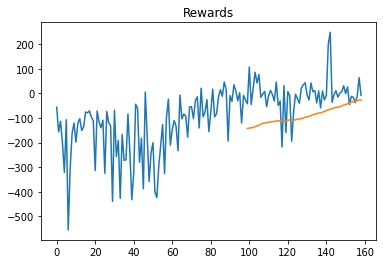

Episode 158 finished after 1000 timesteps with total reward -8.11829653051472


In [ ]:
run_rewards, agent = lander_runner(
    num_episodes=1500,
    target_update=4,
    alpha=0.0005,
    eps=1,
    eps_decay=0.99,
    gamma=0.999,
    seed=57,
    convergence_threshold=210
)